In [1]:
# coding:utf-8
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble, metrics
from datetime import datetime as dt
from sklearn.preprocessing import LabelEncoder


# pandas
import pandas as pd
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_colwidth", 1000)

# LightGBM
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 交差検証
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# AUC
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

/Users/toshiki/py37env/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
purchase_df = pd.read_csv('../input/purchase_record.csv')
user_df = pd.read_csv('../input/user_info.csv')
test_df = pd.read_csv('../input/purchase_record_test.csv')

In [3]:
purchase_df.shape

(1803574, 14)

In [4]:
purchase_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1803574 entries, 0 to 1803573
Data columns (total 14 columns):
user_id        object
purchase_id    object
date           object
product_id     object
parts_1        object
parts_2        object
parts_3        object
parts_4        object
parts_5        object
parts_6        object
parts_7        object
parts_8        object
parts_9        object
purchase       int64
dtypes: int64(1), object(13)
memory usage: 192.6+ MB


In [5]:
purchase_df.head()

,user_id,purchase_id,date,product_id,parts_1,parts_2,parts_3,parts_4,parts_5,parts_6,parts_7,parts_8,parts_9,purchase
0,uid_100,pid_0000000000,2017-09-27,product 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,uid_100,pid_0000000001,2017-09-27,product 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,uid_100002,pid_0000000002,2017-11-23,product 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,uid_100002,pid_0000000003,2017-11-23,product 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,uid_100003,pid_0000000004,2018-02-07,product 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [6]:
purchase_df.fillna(0, inplace=True)

In [7]:
purchase_df.purchase.value_counts()

0    928044
1    875530
Name: purchase, dtype: int64

In [8]:
user_df.shape

(189114, 32)

In [9]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189114 entries, 0 to 189113
Data columns (total 32 columns):
user_id         189114 non-null object
date            189114 non-null object
attribute_1     189114 non-null object
attribute_2     189114 non-null object
attribute_3     189114 non-null object
attribute_4     189114 non-null bool
attribute_5     189114 non-null bool
attribute_6     189114 non-null bool
attribute_7     189114 non-null bool
attribute_8     189114 non-null bool
attribute_9     189114 non-null bool
attribute_10    189114 non-null bool
attribute_11    189114 non-null bool
attribute_12    189114 non-null bool
attribute_13    189114 non-null bool
attribute_14    189114 non-null bool
attribute_15    189114 non-null bool
attribute_16    189114 non-null bool
attribute_17    189114 non-null bool
attribute_18    189114 non-null bool
attribute_19    189114 non-null bool
attribute_20    189114 non-null bool
attribute_21    189114 non-null bool
attribute_22    189114 non-n

In [10]:
user_df.head()

,user_id,date,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,attribute_6,attribute_7,attribute_8,...,attribute_21,attribute_22,attribute_23,attribute_24,attribute_25,attribute_26,attribute_27,attribute_28,attribute_29,attribute_30
0,uid_100,2016-06-29,id 5,id 5,id 5,True,False,False,True,True,...,True,False,True,True,False,False,True,True,True,False
1,uid_100002,2016-01-06,id 28,id 9,id 5,False,False,True,True,False,...,False,False,True,True,True,True,True,True,True,False
2,uid_100003,2017-06-10,id 4,id 8,id 5,True,True,True,True,True,...,True,False,False,True,True,True,True,False,True,True
3,uid_100004,2017-07-20,id 40,id 25,id 9,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
4,uid_100006,2017-07-27,id 40,id 25,id 9,False,False,False,False,False,...,False,False,False,True,False,False,False,True,True,False


In [11]:
test_df.head()

,user_id,purchase_id,date,product_id,parts_1,parts_2,parts_3,parts_4,parts_5,parts_6,parts_7,parts_8,parts_9
0,uid_100,pid_0001803575,2018-08-26,product 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,uid_100,pid_0001803576,2018-08-04,product 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,uid_100,pid_0001803577,2018-08-26,product 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,uid_100,pid_0001803578,2018-08-04,product 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,uid_100003,pid_0001803579,2018-08-02,product 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**学習データ・テストデータを結合**

In [12]:
# data_yに目的変数を代入
y_train = purchase_df['purchase']
# data_yの表示
print( y_train )

# data_Xに説明変数を代入
X_train = purchase_df.drop('purchase', axis=1)
# data_Xの表示
print( X_train )

0          0
1          0
2          1
3          1
4          1
          ..
1803569    1
1803570    1
1803571    1
1803572    1
1803573    1
Name: purchase, Length: 1803574, dtype: int64
            user_id     purchase_id        date product_id parts_1 parts_2  \
0           uid_100  pid_0000000000  2017-09-27  product 2       0       0   
1           uid_100  pid_0000000001  2017-09-27  product 2       0       0   
2        uid_100002  pid_0000000002  2017-11-23  product 2       0       0   
3        uid_100002  pid_0000000003  2017-11-23  product 2       0       0   
4        uid_100003  pid_0000000004  2018-02-07  product 2       0       0   
...             ...             ...         ...        ...     ...     ...   
1803569   uid_99994  pid_0001803569  2018-06-16  product 4       0       0   
1803570   uid_99994  pid_0001803570  2018-03-30  product 4       0       0   
1803571   uid_99994  pid_0001803571  2018-01-19  product 2       0       0   
1803572   uid_99994  pid_000180

In [13]:
all_df = pd.concat([X_train, test_df])

In [14]:
all_df = pd.merge(all_df, user_df, how='left', on='user_id')

In [15]:
all_df.head()

,user_id,purchase_id,date_x,product_id,parts_1,parts_2,parts_3,parts_4,parts_5,parts_6,...,attribute_21,attribute_22,attribute_23,attribute_24,attribute_25,attribute_26,attribute_27,attribute_28,attribute_29,attribute_30
0,uid_100,pid_0000000000,2017-09-27,product 2,0,0,0,0,0,0,...,True,False,True,True,False,False,True,True,True,False
1,uid_100,pid_0000000001,2017-09-27,product 2,0,0,0,0,0,0,...,True,False,True,True,False,False,True,True,True,False
2,uid_100002,pid_0000000002,2017-11-23,product 2,0,0,0,0,0,0,...,False,False,True,True,True,True,True,True,True,False
3,uid_100002,pid_0000000003,2017-11-23,product 2,0,0,0,0,0,0,...,False,False,True,True,True,True,True,True,True,False
4,uid_100003,pid_0000000004,2018-02-07,product 2,0,0,0,0,0,0,...,True,False,False,True,True,True,True,False,True,True


In [16]:
all_df.shape
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2018615 entries, 0 to 2018614
Data columns (total 44 columns):
user_id         object
purchase_id     object
date_x          object
product_id      object
parts_1         object
parts_2         object
parts_3         object
parts_4         object
parts_5         object
parts_6         object
parts_7         object
parts_8         object
parts_9         object
date_y          object
attribute_1     object
attribute_2     object
attribute_3     object
attribute_4     bool
attribute_5     bool
attribute_6     bool
attribute_7     bool
attribute_8     bool
attribute_9     bool
attribute_10    bool
attribute_11    bool
attribute_12    bool
attribute_13    bool
attribute_14    bool
attribute_15    bool
attribute_16    bool
attribute_17    bool
attribute_18    bool
attribute_19    bool
attribute_20    bool
attribute_21    bool
attribute_22    bool
attribute_23    bool
attribute_24    bool
attribute_25    bool
attribute_26    bool
attribute_27 

**特徴量生成**
* product_idをfrequency_encoding 
* user_idをfrequency_encoding
* 顧客情報登録日から購入検討日までの日にち
* 購入日or顧客情報登録日は2015/1/1から何日経っているか
* 商品毎の悩まれる時間の統計量(PC毎の検討時間の長さ)
* ユーザー毎の悩まれる時間の統計量

In [17]:
# product_idをfrequency_encodingする
grouped_product_id = all_df.groupby("product_id").size().reset_index(name='product_id_counts') # 出現回数を計算
# もとのデータセットにカテゴリーをproduct_idとして結合
all_df = all_df.merge(grouped_product_id, how = "left", on = "product_id")
all_df["product_id_frequency"] = all_df["product_id_counts"] / all_df["product_id_counts"].count()
#product_idを削除する
# train_df = train_df.drop('product_id_counts', axis=1)

# ユーザーの出現回数(検討回数)列をfrequency_encodingで追加
grouped_user_id = all_df.groupby("user_id").size().reset_index(name='user_id_counts') # 出現回数を計算
# もとのデータセットにカテゴリーをuser_idとして結合
all_df = all_df.merge(grouped_user_id, how = "left", on = "user_id")
all_df["user_id_frequency"] = all_df["user_id_counts"] / all_df["user_id_counts"].count()
# train_df = train_df.drop('product_id_counts', axis=1)

# データ開始から何日経っているかを表す列を追加date_x
all_df['date_x_days'] = np.nan # 欠損値で埋める
all_df['date_x_days'] = all_df.index.values # インデックス値を使用
all_df['date_x_days'] = pd.to_datetime(all_df['date_x']) # 日付データにリフォーマット
all_df['date_x_days'] = all_df['date_x_days'] - dt(2015,1,1)
all_df['date_x_days'] = all_df['date_x_days'].dt.days
# データ開始から何日経っているかを表す列を追加date_y
all_df['date_y_days'] = np.nan # 欠損値で埋める
all_df['date_y_days'] = all_df.index.values # インデックス値を使用
all_df['date_y_days'] = pd.to_datetime(all_df['date_y']) # 日付データにリフォーマット
all_df['date_y_days'] = all_df['date_y_days'] - dt(2015,1,1)
all_df['date_y_days'] = all_df['date_y_days'].dt.days
# 日付列削除
all_df = all_df.drop('date_x', axis=1)
all_df = all_df.drop('date_y', axis=1)

# 顧客属性登録日から購入検討日までの検討時間列を追加
all_df['days_y_minus_x'] = np.nan # 欠損値で埋める
all_df['days_y_minus_x'] = all_df.index.values # インデックス値を使用
all_df['days_y_minus_x'] = all_df['date_x_days'] - all_df['date_y_days']

# 商品毎の悩まれる時間の統計量(PC毎の検討時間の長さ)
# grouped_product_id = all_df.groupby("product_id").size().reset_index(name='product_id_counts') # 出現回数を計算
# all_df.groupby("product_id").size().reset_index(name='product_id_counts')
grouped_product_id_time = all_df.groupby("product_id").mean().product_id_counts.reset_index(name='product_id_time_mean')
# もとのデータセットにカテゴリーをproduct_idとして結合
all_df = all_df.merge(grouped_product_id_time, how = "left", on = "product_id")

# ユーザー毎の悩まれる時間の統計量
grouped_user_id_time = all_df.groupby("user_id").mean().days_y_minus_x.reset_index(name='user_id_time_mean')
# もとのデータセットにカテゴリーをproduct_idとして結合
all_df = all_df.merge(grouped_user_id_time, how = "left", on = "user_id")

# user_idを削除する
all_df = all_df.drop('user_id', axis=1)

In [18]:
all_df.head()

,purchase_id,product_id,parts_1,parts_2,parts_3,parts_4,parts_5,parts_6,parts_7,parts_8,...,attribute_30,product_id_counts,product_id_frequency,user_id_counts,user_id_frequency,date_x_days,date_y_days,days_y_minus_x,product_id_time_mean,user_id_time_mean
0,pid_0000000000,product 2,0,0,0,0,0,0,0,0,...,False,904561,0.44811,6,2.972335e-06,1000,545,455,904561.0,669.666667
1,pid_0000000001,product 2,0,0,0,0,0,0,0,0,...,False,904561,0.44811,6,2.972335e-06,1000,545,455,904561.0,669.666667
2,pid_0000000002,product 2,0,0,0,0,0,0,0,0,...,False,904561,0.44811,2,9.907783e-07,1057,370,687,904561.0,687.000000
3,pid_0000000003,product 2,0,0,0,0,0,0,0,0,...,False,904561,0.44811,2,9.907783e-07,1057,370,687,904561.0,687.000000
4,pid_0000000004,product 2,0,0,0,0,0,0,0,0,...,True,904561,0.44811,34,1.684323e-05,1133,891,242,904561.0,226.411765


In [19]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2018615 entries, 0 to 2018614
Data columns (total 50 columns):
purchase_id             object
product_id              object
parts_1                 object
parts_2                 object
parts_3                 object
parts_4                 object
parts_5                 object
parts_6                 object
parts_7                 object
parts_8                 object
parts_9                 object
attribute_1             object
attribute_2             object
attribute_3             object
attribute_4             bool
attribute_5             bool
attribute_6             bool
attribute_7             bool
attribute_8             bool
attribute_9             bool
attribute_10            bool
attribute_11            bool
attribute_12            bool
attribute_13            bool
attribute_14            bool
attribute_15            bool
attribute_16            bool
attribute_17            bool
attribute_18            bool
attribute_19      

In [20]:
all_df.shape

(2018615, 50)

In [21]:
all_df.isnull().sum().sum()

1746315

In [22]:
%%time
# train = pd.get_dummies(train_df, drop_first=True)
all = pd.get_dummies(all_df, columns=['product_id', 'attribute_1', 'attribute_2', 'attribute_3', 'parts_1', 'parts_2', 'parts_3', 'parts_4', 'parts_5', 'parts_6', 'parts_7', 'parts_8', 'parts_9'], drop_first=True)
all = all * 1
all = all.set_index('purchase_id')
# train = pd.get_dummies(train_df, columns!=['purchase_id', 'purchase'], drop_first=True)



CPU times: user 5.44 s, sys: 4.34 s, total: 9.78 s
Wall time: 14 s


In [23]:
all.head()

,attribute_4,attribute_5,attribute_6,attribute_7,attribute_8,attribute_9,attribute_10,attribute_11,attribute_12,attribute_13,...,parts_9_id 18,parts_9_id 19,parts_9_id 2,parts_9_id 3,parts_9_id 4,parts_9_id 5,parts_9_id 6,parts_9_id 7,parts_9_id 8,parts_9_id 9
purchase_id,,,,,,,,,,,,,,,,,,,,,
pid_0000000000,1,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pid_0000000001,1,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pid_0000000002,0,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
pid_0000000003,0,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
pid_0000000004,1,1,1,1,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [24]:
all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2018615 entries, pid_0000000000 to pid_0002018615
Columns: 274 entries, attribute_4 to parts_9_id 9
dtypes: float64(4), int64(32), uint8(238)
memory usage: 1.0+ GB


**学習データ・テストデータに分割**

In [25]:
# X_trainに説明変数を代入
X_train = all[:1803574]

# y_trainに目的変数を代入
# y_train = y_train

# テストデータ作成
test = all[1803574:]

In [26]:
# data_Xの表示
X_train.tail()

,attribute_4,attribute_5,attribute_6,attribute_7,attribute_8,attribute_9,attribute_10,attribute_11,attribute_12,attribute_13,...,parts_9_id 18,parts_9_id 19,parts_9_id 2,parts_9_id 3,parts_9_id 4,parts_9_id 5,parts_9_id 6,parts_9_id 7,parts_9_id 8,parts_9_id 9
purchase_id,,,,,,,,,,,,,,,,,,,,,
pid_0001803569,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
pid_0001803570,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
pid_0001803571,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
pid_0001803572,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
pid_0001803573,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# data_yの表示
test.head()

,attribute_4,attribute_5,attribute_6,attribute_7,attribute_8,attribute_9,attribute_10,attribute_11,attribute_12,attribute_13,...,parts_9_id 18,parts_9_id 19,parts_9_id 2,parts_9_id 3,parts_9_id 4,parts_9_id 5,parts_9_id 6,parts_9_id 7,parts_9_id 8,parts_9_id 9
purchase_id,,,,,,,,,,,,,,,,,,,,,
pid_0001803575,1,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pid_0001803576,1,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pid_0001803577,1,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pid_0001803578,1,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pid_0001803579,1,1,1,1,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


fold1 start
Training until validation scores don't improve for 20 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.543088	valid_1's binary_logloss: 0.543493
oof: [1 1 1 ... 1 1 1]
AUC: [0.7294076325079687]
fold1 end

fold2 start
Training until validation scores don't improve for 20 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.542891	valid_1's binary_logloss: 0.542912
oof: [0 1 1 ... 1 1 1]
AUC: [0.7294076325079687, 0.7282698121424017]
fold2 end

fold3 start
Training until validation scores don't improve for 20 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.543147	valid_1's binary_logloss: 0.543965
oof: [1 1 1 ... 1 1 1]
AUC: [0.7294076325079687, 0.7282698121424017, 0.7272655152121474]
fold3 end

fold4 start
Training until validation scores don't improve for 20 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.544892

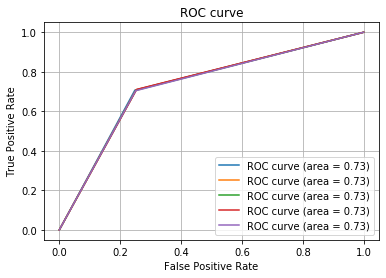

In [28]:
%%time
# 5分割交差検証を指定し、インスタンス化
n_splits = 5
kf = KFold(n_splits, shuffle=True)

# スコアとモデルを格納するリスト
score_list = []
models = []

for fold_, (train_index, valid_index) in enumerate(kf.split(X_train, y_train)):
    print(f'fold{fold_ + 1} start')
    train_x = X_train.iloc[train_index]
    valid_x = X_train.iloc[valid_index]
    train_y = y_train[train_index]
    valid_y = y_train[valid_index]
    # lab.Datasetを使って,trainとvalidを作っておく
    lgb_train= lgb.Dataset(train_x, train_y)
    lgb_valid = lgb.Dataset(valid_x, valid_y)

    # パラメータを定義
    lgbm_params = {'objective': 'binary'}                                                                                               
          
    # 学習
    gbm = lgb.train(params = lgbm_params,
                    train_set = lgb_train, 
                    valid_sets = [lgb_train, lgb_valid],
                    early_stopping_rounds = 20,
                    verbose_eval = -1 # 学習の状況を表示しない
                   )

    oof = (gbm.predict(valid_x) > 0.5).astype(int)
    # oof = gbm.predict(valid_x)
    print('oof:', oof)
    # AUC算出
    # auc = metrics.auc(valid_y, oof)
    auc = roc_auc_score(valid_y, oof)
    score_list.append(auc) # スコアリストに保存
    # score_list.append(np.sqrt(mean_squared_error(valid_y, oof))) #RMSEを出す
    # score_list.append(round(accuracy_score(valid_y, oof)*100,2)) # 正解率Accuracyを出す。(検証用y, 予測結果)
    print('AUC:', score_list)
    models.append(gbm) # 学習が終わったモデルをリストに入れておく
    print(f'fold{fold_ + 1} end\n' )
    
    # FPR, TPR(, しきい値) を算出
    fpr, tpr, thresholds = metrics.roc_curve(valid_y, oof)
    
    # ROC曲線をプロット
    plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)

In [29]:
print(score_list, '平均score', round(np.mean(score_list), 2))

[0.7294076325079687, 0.7282698121424017, 0.7272655152121474, 0.7282678689296569, 0.726631127909961] 平均score 0.73


In [30]:
# 比較
# p = pd.DataFrame({"actual":valid_y,"pred":oof})
# p.plot(figsize=(15,4))
# print("AUC",round(np.mean(score_list), 2))

In [31]:
# テストデータの予測を格納する。テストデータ列数*分割数列のnumpy行列を作成
test_pred = np.zeros((len(test), n_splits))

# 分割検証結果の平均を取る
for fold_, gbm in enumerate(models):
    pred_ = gbm.predict(test) # testを予測
    test_pred[:, fold_] = pred_

result = pd.DataFrame({
    'purchase_id': test.index.values,
    'probability': np.mean(test_pred, axis=1)
    # 'probability': (np.mean(test_pred, axis=1) > 0.5).astype(int)
})

# pred = (np.mean(test_pred, axis=1) > 0.5).astype(int)
# result['probability'] = pred
result.to_csv('../output/submit.csv',header=False,index=False)

In [32]:
test_pred

array([[0.73903919, 0.70667724, 0.69052986, 0.65611209, 0.70417836],
       [0.73903919, 0.72296304, 0.7044429 , 0.65721058, 0.7152572 ],
       [0.73903919, 0.72296304, 0.7044429 , 0.65721058, 0.7152572 ],
       ...,
       [0.75782606, 0.77731195, 0.76476864, 0.77168891, 0.77485204],
       [0.75782606, 0.77731195, 0.76476864, 0.77168891, 0.77485204],
       [0.75782606, 0.77731195, 0.76476864, 0.77168891, 0.77485204]])

In [33]:
np.set_printoptions(threshold=np.inf)
# print(pred_)

In [34]:
import datetime
dt_now = datetime.datetime.now()
print(dt_now)
print("予測完了")

2019-12-06 02:50:58.162209
予測完了


**販売確率の高い上位15の商品ラインナップ** 
全データに対して予測を行い、確率が高いものからソートする

In [35]:
all.head()

,attribute_4,attribute_5,attribute_6,attribute_7,attribute_8,attribute_9,attribute_10,attribute_11,attribute_12,attribute_13,...,parts_9_id 18,parts_9_id 19,parts_9_id 2,parts_9_id 3,parts_9_id 4,parts_9_id 5,parts_9_id 6,parts_9_id 7,parts_9_id 8,parts_9_id 9
purchase_id,,,,,,,,,,,,,,,,,,,,,
pid_0000000000,1,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pid_0000000001,1,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pid_0000000002,0,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
pid_0000000003,0,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
pid_0000000004,1,1,1,1,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [36]:
all_pred = np.zeros((len(all), n_splits))

In [37]:
# 分割検証結果の平均を取る
for fold_, gbm in enumerate(models):
    pred_ = gbm.predict(all) # allを予測
    all_pred[:, fold_] = pred_
    
result = pd.DataFrame({
    'purchase_id': all.index.values,
    'probability': np.mean(all_pred, axis=1)
})

result.to_csv('../output/rankingScore.csv',header=False,index=False)

In [38]:
allPredict_df = pd.read_csv('../output/rankingScore.csv', header=None)
allPredict_df = pd.DataFrame({
    'purchase_id': allPredict_df.iloc[:, 0],
    'predict': allPredict_df.iloc[:,1]
})
allPredictRanking_df = pd.merge(all_df, allPredict_df, how='left', on='purchase_id')
#allPredictRanking_df.head()

In [53]:
allPredictRanking_df = allPredictRanking_df.sort_values('predict', ascending=False)
allPredictRanking_df

,purchase_id,product_id,parts_1,parts_2,parts_3,parts_4,parts_5,parts_6,parts_7,parts_8,...,product_id_counts,product_id_frequency,user_id_counts,user_id_frequency,date_x_days,date_y_days,days_y_minus_x,product_id_time_mean,user_id_time_mean,predict
1622838,pid_0001622838,product 3,0,0,0,0,0,0,0,0,...,250859,0.124273,7052,0.003493,995,2136,-1141,250859.0,-1140.840754,0.991353
1625220,pid_0001625220,product 3,0,0,0,0,0,0,0,0,...,250859,0.124273,7052,0.003493,995,2136,-1141,250859.0,-1140.840754,0.991353
1625184,pid_0001625184,product 3,0,0,0,0,0,0,0,0,...,250859,0.124273,7052,0.003493,996,2136,-1140,250859.0,-1140.840754,0.991353
1625183,pid_0001625183,product 3,0,0,0,0,0,0,0,0,...,250859,0.124273,7052,0.003493,996,2136,-1140,250859.0,-1140.840754,0.991353
1625182,pid_0001625182,product 3,0,0,0,0,0,0,0,0,...,250859,0.124273,7052,0.003493,996,2136,-1140,250859.0,-1140.840754,0.991353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746857,pid_0000746857,product 3,0,0,0,0,0,0,0,0,...,250859,0.124273,4293,0.002127,947,617,330,250859.0,467.759842,0.003447
746791,pid_0000746791,product 3,0,0,0,0,0,0,0,0,...,250859,0.124273,4293,0.002127,937,617,320,250859.0,467.759842,0.003447
745451,pid_0000745451,product 3,0,0,0,0,0,0,0,0,...,250859,0.124273,4293,0.002127,947,617,330,250859.0,467.759842,0.003447
744933,pid_0000744933,product 1,id 20,id 2,id 5,id 3,id 2,id 2,id 1,id 3,...,157614,0.078080,4293,0.002127,947,617,330,157614.0,467.759842,0.003394


In [40]:
allPredictRankingGroup_df = allPredictRanking_df[~allPredictRanking_df.duplicated(subset=["predict"])]
allPredictRankingGroup_df
allPredictRankingGroup_df.to_csv('../output/rankingScoreSort.csv')

In [47]:
allPredictRankingGroup_df = allPredictRankingGroup_df.fillna('0')
allPredictRankingGroupProduct_df = allPredictRankingGroup_df.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,50]]
allPredictRankingGroupProduct_df = allPredictRankingGroupProduct_df.drop('purchase_id', axis=1).reset_index(drop=True)
allPredictRankingGroupProduct_df

,product_id,parts_1,parts_2,parts_3,parts_4,parts_5,parts_6,parts_7,parts_8,parts_9,predict
0,product 3,0,0,0,0,0,0,0,0,0,0.991353
1,product 3,0,0,0,0,0,0,0,0,0,0.991342
2,product 2,0,0,0,0,0,0,0,0,0,0.989891
3,product 2,0,0,0,0,0,0,0,0,0,0.989879
4,product 2,0,0,0,0,0,0,0,0,0,0.985969
...,...,...,...,...,...,...,...,...,...,...,...
560250,product 3,0,0,0,0,0,0,0,0,0,0.003528
560251,product 3,0,0,0,0,0,0,0,0,0,0.003523
560252,product 1,id 7,id 10,id 5,id 5,id 6,id 1,id 1,id 16,id 7,0.003516
560253,product 3,0,0,0,0,0,0,0,0,0,0.003447


In [54]:
allPredictRankingGroupProductGroup_df = allPredictRankingGroupProduct_df.groupby(['product_id', 'parts_1', 'parts_2', 'parts_3', 'parts_4', 'parts_5', 'parts_6', 'parts_7', 'parts_8', 'parts_9']).mean()
allPredictRankingGroupProductGroup_df

predict
product_id parts_1 parts_2 parts_3 parts_4 parts_5 parts_6 parts_7 parts_8 parts_9          
product 1  id 1    id 1    id 1    id 1    id 1    id 1    id 1    id 1    id 1     0.391297
                                                                           id 3     0.671775
                                                                   id 3    id 1     0.383088
                                           id 2    id 1    id 1    id 1    id 1     0.584269
                                           id 3    id 1    id 1    id 1    id 10    0.287267
...                                                                                      ...
product 5  0       0       0       0       0       0       0       0       0        0.759599
product 6  0       0       0       0       0       0       0       0       0        0.519884
                                                                           0        0.589679
product 7  0       0       0       0       0       0       0       0       0        0.452483
                                                                           0        0.520337

[3742 rows x 1 columns]

In [55]:
allPredictRankingGroupProductGroup_df.to_csv('../output/rankingScoreResult.csv')

In [56]:
allPredictRankingGroupProductGroup_df.sort_values('predict', ascending=False).head()

predict
product_id parts_1 parts_2 parts_3 parts_4 parts_5 parts_6 parts_7 parts_8 parts_9          
product 1  id 12   id 2    id 8    id 3    id 3    id 3    id 6    id 9    id 5     0.944519
           id 7    id 2    id 3    id 3    id 1    id 2    id 3    id 4    id 1     0.934662
           id 12   id 1    id 5    id 3    id 1    id 2    id 1    id 4    id 1     0.905044
           id 32   id 2    id 3    id 4    id 1    id 1    id 1    id 6    id 17    0.888498
           id 4    id 5    id 5    id 3    id 6    id 2    id 1    id 7    id 8     0.860666

In [57]:
allPredictRankingGroupProductGroup_df.sort_values('predict', ascending=False).to_csv('../output/rankingScoreResult.csv')